In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import math
import csv
import copy
import numpy as np
import datetime
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

## Preprocessing
Before beginning task 1, we look to see if there are any problems with the data and if there was any cleaning needed. I checked if there were any nulls in the energy data and weather data (null meaning there are no entries in the .csv file in a certain cell in a column) and found that only the weather data cloudCover column had nulls (1470, to be exact). Seeing that we only had about ~8,000 rows in the file, I decided to not drop the data (as we’d be losing about 1/8th of our data) and I used mean interpolation to fill in the missing cells with the mean of the cloudCover values.

In [64]:
# Bring in the two CSV files. 
energy_data = pd.read_csv("energy_data.csv", parse_dates=['Date & Time'])
weather_data = pd.read_csv("weather_data.csv", parse_dates=['time'])

# Clean the data first-- only weather data needs cleaning. Doing mean
# interpolation over the cloudcovers and set the missing valus to mean. 
cloud_cover_mean = weather_data['cloudCover'].mean()
print("CloudCover mean: ",cloud_cover_mean)
weather_data.loc[weather_data['cloudCover'].isna(), 'cloudCover'] = cloud_cover_mean
weather_data.to_csv('c_weather_data.csv', index=False)

CloudCover mean:  0.13797119341563363
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   temperature        8760 non-null   float64       
 1   icon               8760 non-null   object        
 2   humidity           8760 non-null   float64       
 3   visibility         8760 non-null   float64       
 4   summary            8760 non-null   object        
 5   pressure           8760 non-null   float64       
 6   windSpeed          8760 non-null   float64       
 7   cloudCover         8760 non-null   float64       
 8   time               8760 non-null   datetime64[ns]
 9   windBearing        8760 non-null   int64         
 10  precipIntensity    8760 non-null   float64       
 11  dewPoint           8760 non-null   float64       
 12  precipProbability  8760 non-null   float64       
dtypes: datetime64[ns](1), flo

,temperature,icon,humidity,visibility,summary,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,34.98,partly-cloudy-night,0.64,10.00,Partly Cloudy,1017.69,7.75,0.29,2014-01-01 00:00:00,279,0.0,23.89,0.0
1,16.49,clear-night,0.62,10.00,Clear,1022.76,2.71,0.06,2014-01-01 01:00:00,195,0.0,5.87,0.0
2,14.63,clear-night,0.68,10.00,Clear,1022.32,4.84,0.03,2014-01-01 02:00:00,222,0.0,6.17,0.0
3,13.31,clear-night,0.71,10.00,Clear,1021.64,4.00,0.14,2014-01-01 03:00:00,209,0.0,5.63,0.0
4,13.57,clear-night,0.71,9.93,Clear,1020.73,3.67,0.04,2014-01-01 04:00:00,217,0.0,5.87,0.0


In [49]:
# Load the cleaned data back into the var, convert the epoch time to datetime
energy_data = pd.read_csv("energy_data.csv", parse_dates=['Date & Time'])
weather_data = pd.read_csv("c_weather_data.csv")
weather_data['time'] = pd.to_datetime(weather_data['time'], unit='s')

weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   temperature        8760 non-null   float64       
 1   icon               8760 non-null   object        
 2   humidity           8760 non-null   float64       
 3   visibility         8760 non-null   float64       
 4   summary            8760 non-null   object        
 5   pressure           8760 non-null   float64       
 6   windSpeed          8760 non-null   float64       
 7   cloudCover         8760 non-null   float64       
 8   time               8760 non-null   datetime64[ns]
 9   windBearing        8760 non-null   int64         
 10  precipIntensity    8760 non-null   float64       
 11  dewPoint           8760 non-null   float64       
 12  precipProbability  8760 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory us

## Task 1:
I found the sum of all energy usage per day from the energy_data.csv by grouping the records by datetime, and aggregating the “use \[kW\]” into a sum for a day.

To merge with the weather data, we needed to group all the values to be one-row-per-day and “merge” the sum that we found with that day (essentially just adding a column to show that X day used Y energy in kW. So, to merge the weather columns, we notice that there are categorical data instead of numerical data for “icon” and for “summary”. Instead of discarding these columns, I decided to label encode them with LabelEncoder from sklearn. This way, we get a numerical representation of the categorical data and this we are able to combine all the weather values of a day into a single mean for each column for a day. With this, I merge the “use \[kW\]” from part 1 to their respective weather day.



In [50]:
# Task 1: Get the sum energy useage for a day. For the weather data, create a 
# new column. For the values of the column, it would be the sum energy useage
# for this specific day in the wewather data. This means: for a given sum 
# energy useage for a day, the weather data will have multiple repeats of
# the same value (for the whole day in the weather data, it would have the same
# sum value.)

per_day_group = energy_data.groupby(energy_data['Date & Time'].dt.date).agg( {
    'use [kW]': 'sum',
}).reset_index()
per_day_sum = per_day_group.sum(axis=1)
day_total_map = {}
for i in range(len(per_day_group['Date & Time'])):
    day_total_map[per_day_group['Date & Time'][i]] = per_day_sum[i]
    
# Merge all the weather_data into one row per day. 
# First, label encode all the `icon` and the `summary` fields. 
icon_le = preprocessing.LabelEncoder()
icon_le.fit(weather_data['icon'])
weather_data['icon'] = icon_le.transform(weather_data['icon'])
summary_le = preprocessing.LabelEncoder()
summary_le.fit(weather_data['summary'])
weather_data['summary'] = summary_le.transform(weather_data['summary'])

# Now find the mean of all columns per day and make them all one row. 
weather_data = weather_data.groupby(weather_data['time'].dt.date).agg( {
    'temperature': 'mean',
    'icon': 'mean',
    'humidity': 'mean',
    'visibility': 'mean',
    'summary': 'mean',
    'pressure': 'mean',
    'windSpeed': 'mean',
    'cloudCover': 'mean',
    'windBearing': 'mean',
    'precipIntensity': 'mean',
    'dewPoint': 'mean',
    'precipProbability': 'mean'
}).reset_index()

# Store a copy of the cleaned, single row representation. 
weather_data_copy = weather_data.copy()

# Now create a new column to the dataframe to hold the sums for the day. 
weather_data['energy [kW]'] = np.nan
for day in day_total_map:
    weather_data.loc[weather_data['time'] == day, 'energy [kW]'] = day_total_map[day]
weather_data['time'] = pd.to_datetime(weather_data['time'])
# weather_data.head(10)


## Task 2
To split the data, we note that we are going to try to predict the energy usage for all of December. So, the training data will be all days from January-November, and then the test data will be all the days of December. 
For the training data, I got the training features to be all columns except for the “time” column and the “energy \[kW\]” column for all rows. This is X_train. For the Y_train, the values are going to be the vector of values from “energy \[kW\]”. 
For the test data, I did the exact same thing. These will be referred to as X_test and Y_test. 

With the given visual, we can see that the training data is generally not entirely linear. 

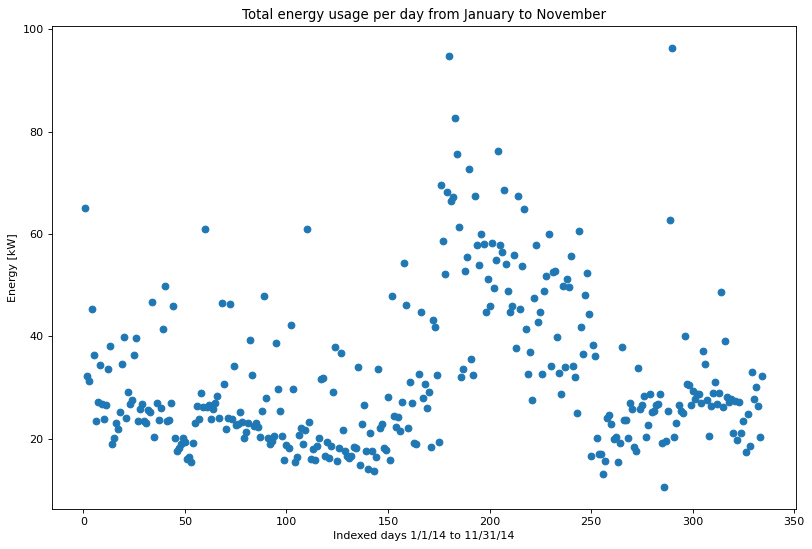

,temperature,icon,humidity,visibility,summary,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,energy [kW]
temperature,1.000000,0.063383,0.322137,0.104422,0.208661,-0.205136,-0.226581,0.245563,-0.108984,0.116522,0.966929,0.106991,0.369090
icon,0.063383,1.000000,0.583050,-0.643041,0.865273,-0.393242,0.199177,0.765481,-0.230437,0.700426,0.209205,0.843004,0.001183
humidity,0.322137,0.583050,1.000000,-0.662128,0.561071,-0.206905,-0.307849,0.661856,-0.421354,0.470280,0.549459,0.581198,0.095370
visibility,0.104422,-0.643041,-0.662128,1.000000,-0.474641,0.214076,0.070652,-0.472551,0.298258,-0.530633,-0.070033,-0.654113,0.057940
summary,0.208661,0.865273,0.561071,-0.474641,1.000000,-0.365432,0.087623,0.846790,-0.184166,0.620442,0.336401,0.681244,0.060703
pressure,-0.205136,-0.393242,-0.206905,0.214076,-0.365432,1.000000,-0.361599,-0.372784,-0.291300,-0.252463,-0.237483,-0.298298,-0.064362
windSpeed,-0.226581,0.199177,-0.307849,0.070652,0.087623,-0.361599,1.000000,0.068037,0.277942,0.127482,-0.275908,0.105010,-0.112268
cloudCover,0.245563,0.765481,0.661856,-0.472551,0.846790,-0.372784,0.068037,1.000000,-0.247450,0.480132,0.395449,0.589886,0.001558
windBearing,-0.108984,-0.230437,-0.421354,0.298258,-0.184166,-0.291300,0.277942,-0.247450,1.000000,-0.280751,-0.205763,-0.312450,0.017890
precipIntensity,0.116522,0.700426,0.470280,-0.530633,0.620442,-0.252463,0.127482,0.480132,-0.280751,1.000000,0.223141,0.895111,0.073776


In [51]:
# Part 2: Split the csv file to training and test data sets. According to file,
# everything that is not of month December are training, and December is test
X_train = weather_data.loc[weather_data['time'].dt.month != 12].iloc[:, 1:]
Y_train = X_train['energy [kW]']

days = weather_data.loc[weather_data['time'].dt.month == 12].iloc[:, 0].reset_index()
X_test = weather_data.loc[weather_data['time'].dt.month == 12].iloc[:,1:]
Y_test = X_test['energy [kW]']

# Vizualize the training data Y values (energy [kW])
dummy = weather_data.loc[weather_data['time'].dt.month != 12]
training_dates = []
for day in dummy['time']:
    training_dates.append(day.date().strftime("%m/%d/%Y"))
train_days = list(range(1,len(dummy['time'])+1))
plt.figure(figsize=(12,8), dpi = 80)
plt.scatter(train_days, Y_train)
plt.ylabel("Energy [kW]")
plt.xlabel("Indexed days 1/1/14 to 11/31/14")
plt.title("Total energy usage per day from January to November")
plt.show()

weather_data.corr()

#### Feature selection for Linear Regression
Before performing task 3, I chose to use only the highest-correlated features to train the model on. This was done by checking the pairwise correlation between all columns of the training data and then dropping some columns so that our model will only train on the most relevant features. 

In [52]:
# Drop lower-correlated columns in effort to increase the RMSE. temperature, 
mX_train = X_train.loc[:, ['temperature', 'windSpeed', 'dewPoint']]
mX_test = X_test.loc[:, ['temperature', 'windSpeed', 'dewPoint']]

## Task 3: Linear Regression
To run linear regression, we use sklearn to do the heavy lifting for us. I import LinearRegression from sklearn and just follow the documentation. I call reg = LinearRegression().fit() with the parameters X_train so the model can learn from the features and Y_train so the model will know what energy \[kW\] is going to be associated with each row of features it’s learning from. 

After the model is fit, we run reg.predict() on the X_test, which is the testing data. This will return us a vector of  energy \[kW\] values that the model will predict for all days of december given their features. 

For analysis, I decided to employ univariate linear regression and multivariate linear regression. 

#### Univariate linear regression: 
We tested all columns, and found that generally 'temperature' was the best that gave the lowest RMSE value. 

Slope:  0.2958838816614941  Intercept:  17.388037911022522
RMSE is:  7.222114014811936
Score is:  -0.03568446992845664


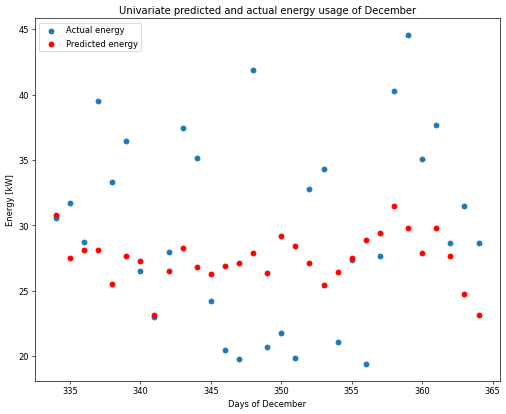

In [55]:
X_tr = X_train['temperature'].values.reshape(-1,1)
X_te = X_test['temperature'].values.reshape(-1,1)

univariate_reg = LinearRegression().fit(X_tr, Y_train)
print("Slope: ", univariate_reg.coef_[0], " Intercept: ", univariate_reg.intercept_)
uni_test_pred = univariate_reg.predict(X_te)

# Get the mean square error
MSE = np.mean((uni_test_pred - Y_test)**2)
RMSE = math.pow(mean_squared_error(Y_test, uni_test_pred), .5)
print("RMSE is: ", RMSE)

# Find the R^2 score:
score = univariate_reg.score(X_te, Y_test)
print("Score is: ", score)

with open('part2.csv', 'w+', newline='') as f:
    writer = csv.writer(f)
    for i in range(len(uni_test_pred)):
        writer.writerow([days['time'][i], uni_test_pred[i]])


test_days = list(range(334, 365))
plt.figure(figsize=(10,8), dpi = 60)
plt.scatter(test_days, Y_test, label = "Actual energy")
plt.scatter(test_days, uni_test_pred, color="red", label = "Predicted energy")
# plt.plot(test_days, test_pred, color = 'red', linewidth = 3)
plt.title("Univariate predicted and actual energy usage of December")
plt.legend()
plt.xlabel("Days of December")
plt.ylabel("Energy [kW]")
plt.show()


#### Multivariate Linear Regression
We only trained on the features that had a relatively high correlation value to the energy, which were \['temperature', 'windSpeed', 'dewPoint'\].

Slope:  0.28212807087589653  Intercept:  18.87790826523585
RMSE is:  7.2417642272803855
Score is:  -0.041327999320336595


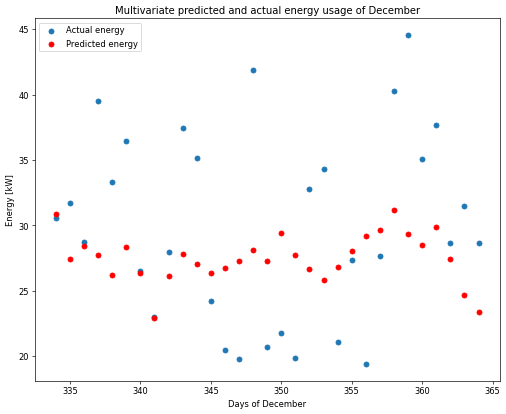

In [56]:
# Part 3: Linear Regression

multivariate_reg = LinearRegression().fit(mX_train, Y_train)
print("Slope: ", multivariate_reg.coef_[0], " Intercept: ", multivariate_reg.intercept_)
test_pred = multivariate_reg.predict(mX_test)

# Get the mean square error
MSE = np.mean((test_pred - Y_test)**2)
RMSE = math.pow(mean_squared_error(Y_test, test_pred), .5)
print("RMSE is: ", RMSE)

# Find the R^2 score:
score = multivariate_reg.score(mX_test, Y_test)
print("Score is: ", score)

test_days = list(range(334, 365))
plt.figure(figsize=(10,8), dpi = 60)
plt.scatter(test_days, Y_test, label = "Actual energy")
plt.scatter(test_days, test_pred, color="red", label = "Predicted energy")
# plt.plot(test_days, test_pred, color = 'red', linewidth = 3)
plt.title("Multivariate predicted and actual energy usage of December")
plt.legend()
plt.xlabel("Days of December")
plt.ylabel("Energy [kW]")
plt.show()

# weather_data.head(10)

#### Task 3 Analysis
We see that in both our univariate and multivariate linear regression, we get comparable results, so we apply Occam's razor and analyze our univariate model, since we trained on less features and got similar results. 

We see that the model we built was not the best in predicting the total energy usage for a day, but still works fairly well. We see that our RMSE, which measures how far off the actual data points were from our predicted value, value was 7.22. By manual analysis and comparing our predicted values to the actual energy usage for the day in December, we see that our predictions weren't terribly far off. The downside to our model was that our R^2 value was essentially 0, meaning that the model, given the temperature, was almost always giving a value that was around 30kW of energy useage. Though our model isn't accurate, we do have lower RMSE values so the predictions are still decent. 

## Task 4
For logistic regression, the initial setup is about the same for linear regression. We split the weather_data into two sets: the training data and the evaluation data. The training data are all rows of per-day weather data from Januray to the end of November, and the test data is the weather data for all of December. 

For logistic regression, I some columns of least correlation to the temperature, namely the icon, summary, visibility, and windBearing fields and saw no changes to the f-score. So, by training on less features and still getting similar (in this case, the same) results, I decided to stick with dropping the columns. 

To make the logistic regression run better, I utilized feature selection and feature scaling from sklearn. I made a pipeline of a StandardScaler() to scale the values in the data, then I utilized SelectPercentile to grab the features that had the highest scores in getting better predictions from the model and then called LogisticRegression() on the tuned results. This led to a f-score of 0.87.


In [43]:
# Part 4: Logistic Regression for Temperatireu classification
# Using only weather data, classify if the temperature is high or low.
# x >= 35 is high, < 35 is low where x is temerature. 1 = high 0 = low

# Reload weather_data that was merged into one row. without the energy data. 
weather_data = weather_data_copy
weather_data['time'] = pd.to_datetime(weather_data['time'])
# weather_data.info()
# Transform the temperature data to be 0 or 1 based on the condition. 
# Split the data again. 
X_train = weather_data.loc[weather_data['time'].dt.month != 12].iloc[:, 1:]
Y_train = X_train['temperature'].reset_index()
X_train = X_train.drop(columns = ['temperature', 'icon', 'summary', 
                                  'visibility', 'windBearing'])

X_test = weather_data.loc[weather_data['time'].dt.month == 12].iloc[:,1:]
Y_test = X_test['temperature'].reset_index()
X_test_temp = X_test['temperature'].reset_index()
X_test = X_test.drop(columns = ['temperature', 'icon', 'summary', 
                                'visibility', 'windBearing'])


# Transform the temperature data to be 0 or 1 based on the condition. 
Y_train.loc[Y_train['temperature'] <  35, 'temperature'] = 0
Y_train.loc[Y_train['temperature'] >= 35, 'temperature'] = 1
Y_test.loc[Y_test['temperature'] <  35, 'temperature'] = 0
Y_test.loc[Y_test['temperature'] >= 35, 'temperature'] = 1

pipe = make_pipeline(StandardScaler(), 
                     SelectPercentile(percentile=20), 
                     LogisticRegression(solver="saga", C=4, max_iter = 5000))

clf = pipe.fit(X_train, Y_train['temperature'])
log_pred = clf.predict(X_test)
results = metrics.classification_report(Y_test['temperature'], log_pred, output_dict = True)
print('F-score of logistic regression model: ', results['macro avg']['f1-score'])

X_test_temp.loc[X_test_temp['temperature'] < 35, 'temperature'] = 0
X_test_temp.loc[X_test_temp['temperature'] >= 35, 'temperature'] = 1

print('{:10s} {:4s} {:4s}'.format("day", "actual", "predicted"))
for i in range(len(days['time'])):
    print('{:11s} {:5d} {:9d}'.format(
        days['time'][i].date().strftime("%m/%d/%Y"), 
        int(X_test_temp['temperature'][i]), 
        int(log_pred[i])))
    
with open('part3.csv', 'w+', newline='') as f:
    writer = csv.writer(f)
    for i in range(len(log_pred)):
        writer.writerow([days['time'][i], log_pred[i]])


F-score of logistic regression model:  0.8708333333333333
day        actual predicted
12/01/2014      1         1
12/02/2014      0         1
12/03/2014      1         1
12/04/2014      1         1
12/05/2014      0         0
12/06/2014      0         1
12/07/2014      0         0
12/08/2014      0         0
12/09/2014      0         0
12/10/2014      1         1
12/11/2014      0         0
12/12/2014      0         0
12/13/2014      0         0
12/14/2014      0         0
12/15/2014      1         1
12/16/2014      0         0
12/17/2014      1         1
12/18/2014      1         1
12/19/2014      0         0
12/20/2014      0         0
12/21/2014      0         0
12/22/2014      0         1
12/23/2014      1         1
12/24/2014      1         1
12/25/2014      1         1
12/26/2014      1         1
12/27/2014      1         1
12/28/2014      1         1
12/29/2014      0         1
12/30/2014      0         0
12/31/2014      0         0


## Task 5
For task 5, I decided to look at the average energy usage of an A/C and a microwave at specific times throughout the year. To do so, I group the entire energy data csv file by a certain time, say 06:00 (6AM), and then find the mean energy usage of one of the devices during that time over the entire year. 

In [44]:
# Group by time (6:30). For all days (01/01-12/31) at this time interval, average the energy useage. Save this avg for this
# specific time in a dict. ( {time : avg_energy} ) 

# Get the time intervals (6:30, 7:00, 7:30, ... for a dataframe)
def getTimeInterval(df): 
    time_intervals = {}
    #Get all time intervals first
    for i in df['Date & Time']:
        if i.time() not in time_intervals:
            time_intervals[i.time()] = 0
        else:
            break
    return time_intervals

ac_dict = getTimeInterval(energy_data)
micro_dict = getTimeInterval(energy_data)

times = list(map(lambda x: x.strftime('%H:%M'), micro_dict.keys()))
d_st = times.index('06:00')
d_ed = times.index('19:00')
times = times[d_st:d_ed] + times[d_ed:] + times[0:d_st]

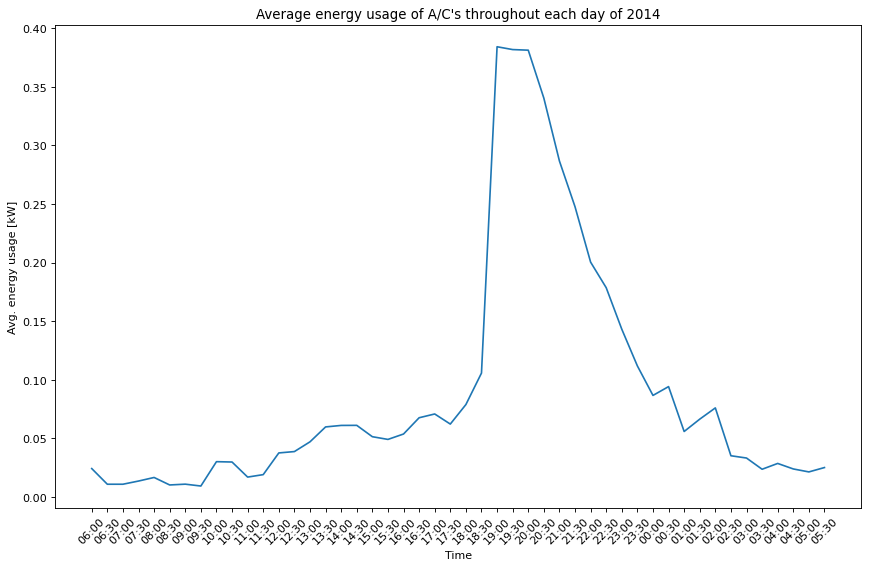

In [45]:
# For AC data: 

for time in ac_dict: 
    # Finding average for the day
    ac_dict[time] = energy_data.loc[energy_data['Date & Time'].dt.time == time]['AC [kW]'].mean()

# Plot the AC usage first 
avg_kw = list(ac_dict.values())
avg_kw = avg_kw[d_st:d_ed] + avg_kw[d_ed:] + avg_kw[0:d_st]
ac_avgKw = copy.deepcopy(avg_kw)
plt.figure(figsize=(13, 8), dpi=80)
plt.plot(times, avg_kw)
plt.xticks(rotation = 45)
plt.title("Average energy usage of A/C's throughout each day of 2014")
plt.xlabel("Time")
plt.ylabel("Avg. energy usage [kW]")
plt.show()



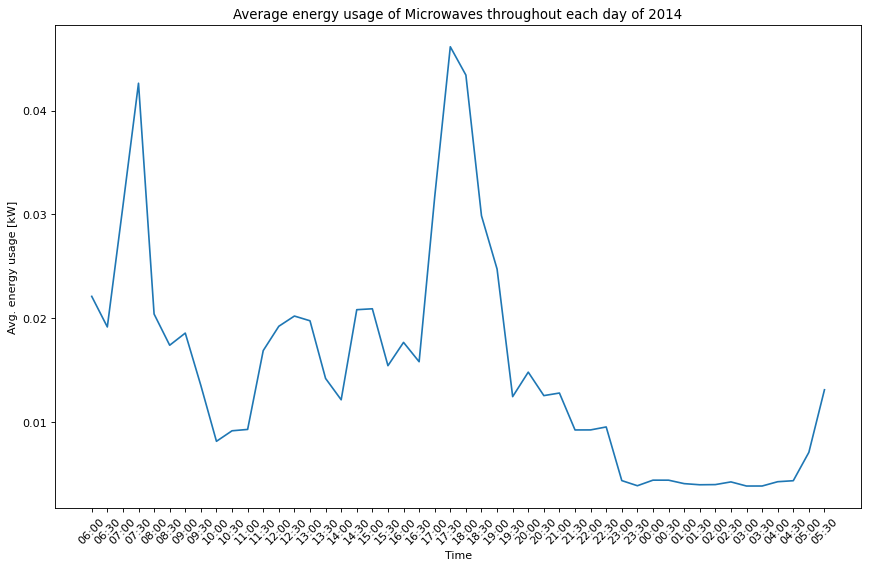

In [46]:
# For microwave data:
for time in micro_dict:
    micro_dict[time] = energy_data.loc[energy_data['Date & Time'].dt.time == time]['Microwave (R) [kW]'].mean()
avg_kw = list(micro_dict.values())
avg_kw = avg_kw[d_st:d_ed] + avg_kw[d_ed:] + avg_kw[0:d_st]
plt.figure(figsize=(13, 8), dpi=80)
plt.plot(times, avg_kw)
plt.xticks(rotation = 45)
plt.title("Average energy usage of Microwaves throughout each day of 2014")
plt.xlabel("Time")
plt.ylabel("Avg. energy usage [kW]")
plt.show()

#### Task 5 Analysis
For analysis, let's take a look at the combined graph of the average energy usage for both A/Cs and microwaves. 

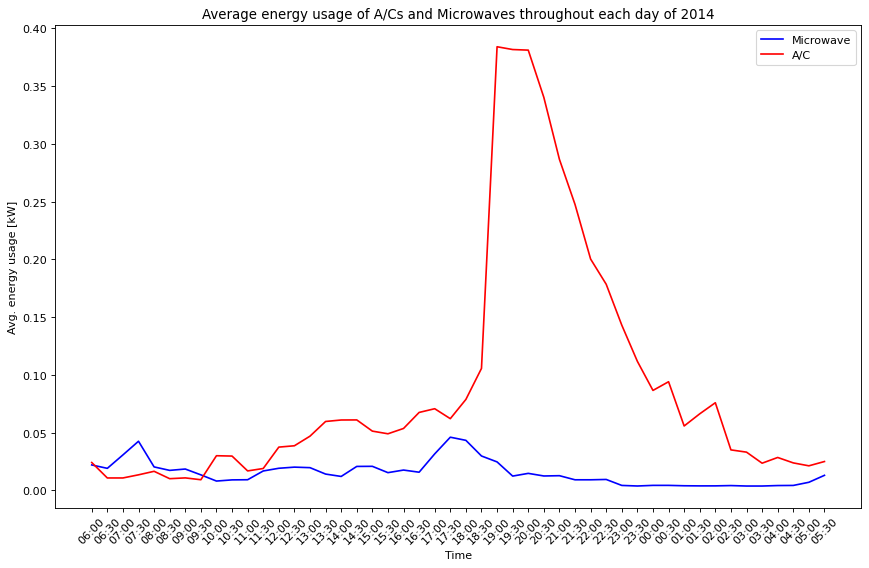

In [47]:
plt.figure(figsize=(13, 8), dpi=80)
plt.plot(times, avg_kw, color = "blue", label = "Microwave")
plt.plot(times, ac_avgKw, color = "red", label = "A/C")
plt.xticks(rotation = 45)
plt.legend()
plt.title("Average energy usage of A/Cs and Microwaves throughout each day of 2014")
plt.xlabel("Time")
plt.ylabel("Avg. energy usage [kW]")
plt.show()

#### A/C
We immediately observe that A/Cs have a greatly higher energy consumption than microwaves. Looking at the A/C energy consumption, we see that in the daytime (defined to be 6AM - 7PM), A/Cs aren't used as much. The average energy consumption for the A/Cs during that time of day ends up being even lower than a microwave, despite A/Cs using much more energy on use. We see that around close to the end of daytime (around 17:00, which is ~5PM), the average energy usage for the A/C spikes up greatly to about 0.40 kW. In extrapolating this data, we can make assumptions to the population for why this might be-- it could be that around this time is when a majority of people return home from work, so the energy data will show increases at the start of nighttimes. The energy used by the A/Cs gradually lower off from the time range 19:00 to about 01:00. Again, we can make assumptions from the data as to why-- people would normally begin to sleep at later times, so it might be the case that people turn off the A/Cs while sleeping (or even have a timer for when the A/C will automatically turn off) so that they can conserve energy, or maybe so that they won't have to pay too much for energy usage. 

It is noted that there are many other factors in analyzing A/C usage, such as the season, the temperature, and etc. In utilizing our energy data alone, we do not have access to this information. We can only make some observations from what we have. If we pair the A/C usage with the weather data csv that we have, we might be able to answer other interesting questions such as: "What is the general temperature in which people find it 'too hot' and end up using their A/C?". 

#### Microwave
Looking at the microwave enregy consumption, we see that the average energy usage is much less than that of an A/C, however there are some trends of A/C usage that are obsreved in microwave energy usage. Specifically, close to the end of daytime (again, around 17:00), we see a spike in the average energy usage of microwaves. This can again be explained by our assumption about people-- that around this time is when a majority of people return home from work, so the energy data will show increases at the start of nighttimes. This spike in microwave usage could also tell us more interesting information for when people normally make food. We see that the microwave energy hass a spike at the very start of daytime: 06:00. This tells us that maybe people get up at around this time to get ready for their day, and that this is the time in which people make breakfast. We can also say the same for the spike in energy at 17:00, this can be the general time in which people will start preparing dinner. 

#### General trends
Overall, we can see some trends about our population, presumably people, with our charts. We see that there is lack of energy activity in nighttime (specifically around 0:00 to 06:00). We can make some observations from such and say that on average, based on the energy usage of a household, people sleep about 6-8 hours a day. Another trend we see is that from late morning to the beginning of nighttime (07:30 to 17:00), there is a lack of energy usage from our charts. We can then make another observation and say that it is possible that people generally work, on average, from 7:30 to 17:00. 